numpy ver.: 1.23.5
pandas ver.: 2.0.1
tensorflow ver.: 2.12.0
keras ver.: 2.12.0
Mean: 87.6126984126984
Median: 76.0
Mode: 70
Standard Deviation: 59.027566226153915
Variance: 3484.2535745829864
Range: 1043


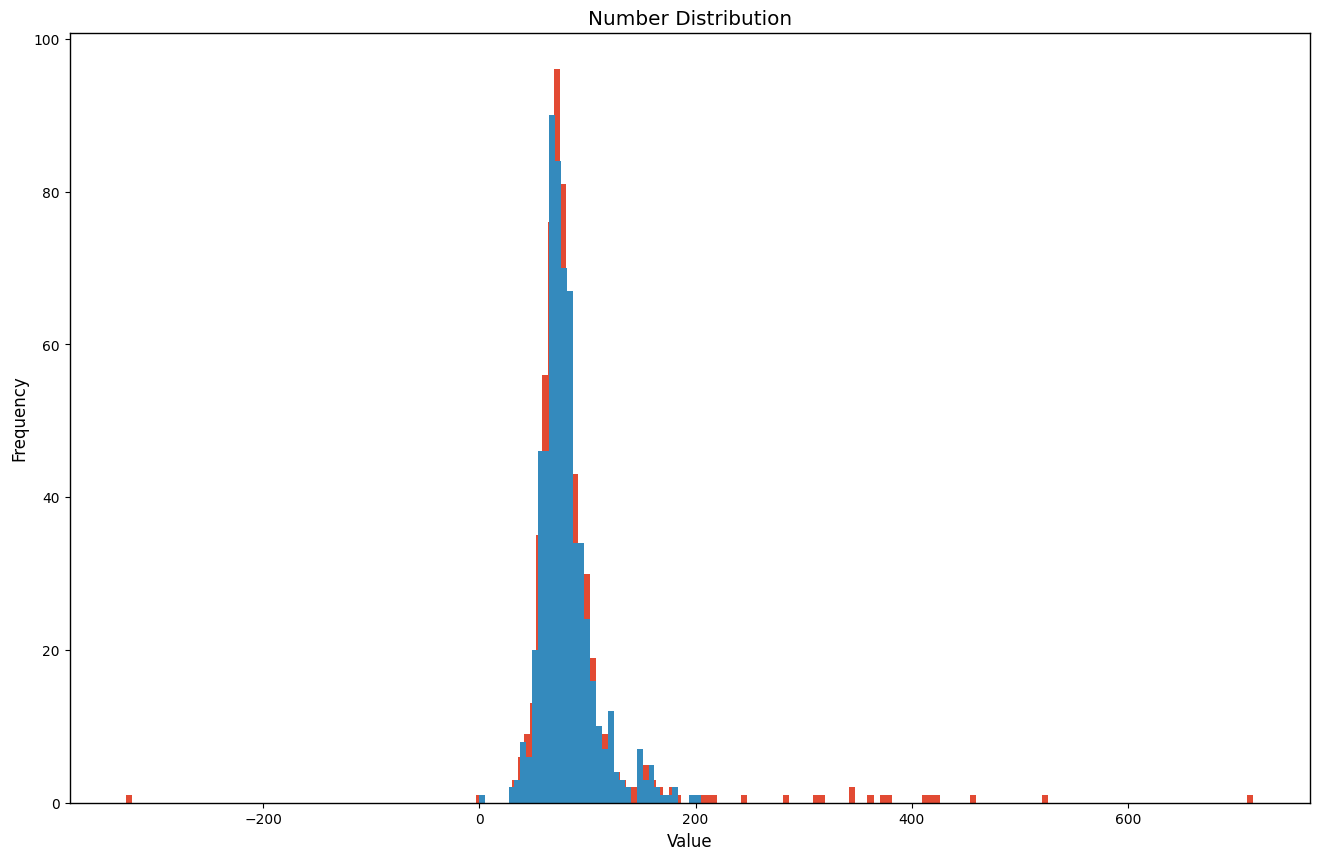

Number of values within 5 units from the mean: 79 : 12.53968253968254%
Number of values within 10 units from the mean: 174 : 27.61904761904762%
Number of values within 20 units from the mean: 384 : 60.952380952380956%


In [76]:
import os
import pickle
import datetime as dt
import itertools

import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

W = 36
U = 45

with open('../data/VMs.pickle', 'rb') as file:
    VMs_df = pickle.load(file)

# Filter rows with ID == "13016_1"
line16_df = VMs_df[VMs_df['ID'] == '13016_1'].copy()

line16_df['Day'] = pd.to_datetime(line16_df['OriginAimedDepartureTime']).dt.date
line16_df.sort_values(by=['Day'])
line16_days_dfs = [group_df.sort_values(['OriginAimedDepartureTime', 'stopOrder']) for _, group_df in line16_df.groupby('Day')]

# Amount of links
linkrefs = ['1089:9944', '9944:90', '90:2830', '2830:363', '363:365',
       '365:366', '366:367', '367:1428', '1428:2005', '2005:1825',
       '1825:105', '105:2781', '2781:2780', '2780:1336', '1336:112',
       '112:3859', '3859:115', '115:117', '117:119', '119:121', '121:123',
       '123:125', '125:127', '127:129', '129:9935', '9935:131',
       '131:1223', '1223:388', '388:172', '172:175', '175:177', '177:179',
       '179:278', '278:279', '279:5834', '5834:9897', '9897:547',
       '547:197', '197:551', '551:242', '242:554', '554:555', '555:5975',
       '5975:545', '545:2071']
assert(U == len(linkrefs))

# Amount of routs
routs_num = [
       '06:50:00.000', '07:10:00.000',
       '07:30:00.000', '07:50:00.000',
       '08:10:00.000', '08:40:00.000',
       '09:00:00.000', '09:30:00.000',
       '10:00:00.000', '10:30:00.000',
       '11:00:00.000', '11:30:00.000',
       '12:00:00.000', '12:30:00.000',
       '13:00:00.000', '13:30:00.000', 
       '14:00:00.000', '14:30:00.000', 
       '15:00:00.000', '15:30:00.000', 
       '16:00:00.000', '16:30:00.000', 
       '17:00:00.000', '17:30:00.000', 
       '18:00:00.000', '18:30:00.000', 
       '19:00:00.000', '19:30:00.000', 
       '20:00:00.000', '20:30:00.000', 
       '21:00:00.000', '21:35:00.000', 
       '22:10:00.000', '22:40:00.000', 
       '23:10:00.000', '23:40:00.000']
assert(W == len(routs_num))

tensor_shape_X = (len(routs_num), len(linkrefs), 1)
tensor_shape_Y = (len(linkrefs), 1)

VALID_MISS = 5
line16_default_tensor = np.zeros(tensor_shape_X)
line16_default_small_tensor = np.zeros(tensor_shape_Y)

for n, day_df in enumerate(line16_days_dfs):
    for (_, group_df) in day_df.groupby('OriginAimedDepartureTime'):
        for (_, row) in group_df.iterrows():
            time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
            if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                w_index = routs_num.index(time)
                u_index = linkrefs.index(row['Linkref'])
                
                line16_default_tensor[w_index, (u_index), 0] = (line16_default_tensor[w_index,(u_index), 0] + row['linkTime']) / 2
                # FIXME <something> / 2 it a moving average
                line16_default_small_tensor[(u_index), 0] = (line16_default_small_tensor[(u_index), 0] + row['linkTime']) / 2

tensors_X = []
tensors_Y = []

tensors_X1 = []
tensors_Y1 = []

for n, day_df in enumerate(line16_days_dfs):
    tensor_X = np.zeros(tensor_shape_X)
    for (_, group_df) in day_df.groupby('OriginAimedDepartureTime'):
            valid_u = ([0] * len(linkrefs))
            u_index = 0
            for (_, row) in group_df.iterrows():
                time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
                if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                    valid_u[u_index] = row['linkTime']
                    u_index+=1

            w_index = 0
            u_index = 0
            for (_, row) in group_df.iterrows():
                time = pd.to_datetime(row['OriginAimedDepartureTime']).strftime("%H:%M:00.000")
                if time in routs_num and row['Linkref'] in linkrefs and len(group_df) > (U - VALID_MISS):
                    w_index = routs_num.index(time)
                    u_index = linkrefs.index(row['Linkref'])
                    
                    tensor_X[w_index, u_index, 0] = row['linkTime']
                    
                
                for u in range(u_index):
                    if tensor_X[w_index, u, 0] == 0:
                        tensor_X[w_index, u, 0] = line16_default_tensor[w_index, u, 0]

                tensors_X.append(tensor_X.copy())
                tensors_X1.append(tensor_X.copy()[w_index])

                tensor_Y = np.zeros(tensor_shape_Y)
                tensor_Y[u_index:, 0] = valid_u[u_index:]
                tensors_Y.append(tensor_Y)
                try:
                    tensors_Y1.append(valid_u[u_index+1])
                except:
                    a =tensors_X1.pop()

tensors_X1 = [list(itertools.chain.from_iterable(tensor.tolist())) for tensor in tensors_X1]

from sklearn.model_selection import train_test_split

tensors_X10stations = []
tensors_Y10stations = []

FULL_STATIONS = 9

for i, tensor in enumerate(tensors_X1):
    if tensor[FULL_STATIONS] != 0.0 and tensor[FULL_STATIONS+1] == 0.0:
        tensors_X10stations.append(tensors_X1[i][:FULL_STATIONS+1])
        tensors_Y10stations.append(tensors_Y1[i])

X10_train, X10_test, Y10_train, Y10_test = train_test_split(tensors_X10stations, tensors_Y10stations, test_size=0.05, random_state=42, shuffle=False)
# Split the training set into a training and validation set
x_train10, x_val10, y_train10, y_val10 = train_test_split(X10_train, Y10_train, test_size=0.1, random_state=42, shuffle=False)

import statistics

# Calculate the mean
mean = statistics.mean(Y10_train)

# Calculate the median
median = statistics.median(Y10_train)

# Calculate the mode
mode = statistics.mode(Y10_train)

# Calculate the standard deviation
std_dev = statistics.stdev(Y10_train)

# Calculate the variance
variance = statistics.variance(Y10_train)

# Calculate the range
data_range = max(Y10_train) - min(Y10_train)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("Range:", data_range)

# Define the threshold as 2 standard deviations
threshold = 2 * std_dev
# Remove outliers from the list
Y10_train_without_outliers = [x for x in Y10_train if (mean - threshold) <= x <= (mean + threshold)]
mean_without_outliers = statistics.mean(Y10_train_without_outliers)

# Create a histogram plot
plt.hist(Y10_train, bins='auto')
plt.hist(Y10_train_without_outliers, bins='auto')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number Distribution')

# Display the plot
plt.show()

distances = [5, 10, 20]
# Count the number of values within each distance
count_within_distance = [len([x for x in Y10_train if abs(x - mean) <= distance]) for distance in distances]
# Calculate the percentage of values within each distance
percentage_within_distance = [count / len(Y10_train) * 100 for count in count_within_distance]
# Print the counts
for i, distance in enumerate(distances):
    print(f"Number of values within {distance} units from the mean: {count_within_distance[i]} : {percentage_within_distance[i]}%")

In [77]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_accuracy(y_true, y_pred):
    # Compute the absolute difference between y_true and y_pred
    abs_diff = K.abs(mean_without_outliers - y_pred)

    # Convert boolean values to float32 for accuracy calculation
    accuracy = K.cast(abs_diff < 10.0, 'float32')

    return accuracy

def custom_distance_accuracy(y_true, y_pred):
    # Compute the absolute difference between y_true and y_pred
    abs_diff = K.abs(y_true - y_pred)

    # Convert boolean values to float32 for accuracy calculation
    accuracy = K.cast(abs_diff, 'float32')

    return accuracy

def build_model():
    model = Sequential()

    model.add(Dense(units=64, input_shape=(FULL_STATIONS+1,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(), loss = "MAE", metrics=[custom_accuracy, custom_distance_accuracy, tf.keras.metrics.MeanAbsoluteError()])
    
    return model

In [78]:
model = build_model()

history = model.fit(X10_train, Y10_train,
                    #batch_size = len(X10_train)-1, 
                    epochs = 100,
                    shuffle = True,
                    verbose = 2, validation_data=(x_val10, y_val10))

Epoch 1/100
20/20 - 1s - loss: 42.9501 - custom_accuracy: 0.2016 - custom_distance_accuracy: 42.9501 - mean_absolute_error: 42.9501 - val_loss: 27.2418 - val_custom_accuracy: 0.2698 - val_custom_distance_accuracy: 27.2418 - val_mean_absolute_error: 27.2418 - 925ms/epoch - 46ms/step
Epoch 2/100
20/20 - 0s - loss: 32.1682 - custom_accuracy: 0.3413 - custom_distance_accuracy: 32.1682 - mean_absolute_error: 32.1682 - val_loss: 31.1549 - val_custom_accuracy: 0.1746 - val_custom_distance_accuracy: 31.1549 - val_mean_absolute_error: 31.1549 - 132ms/epoch - 7ms/step
Epoch 3/100
20/20 - 0s - loss: 27.2300 - custom_accuracy: 0.4127 - custom_distance_accuracy: 27.2300 - mean_absolute_error: 27.2300 - val_loss: 22.9731 - val_custom_accuracy: 0.3968 - val_custom_distance_accuracy: 22.9731 - val_mean_absolute_error: 22.9731 - 150ms/epoch - 8ms/step
Epoch 4/100
20/20 - 0s - loss: 24.4774 - custom_accuracy: 0.4063 - custom_distance_accuracy: 24.4774 - mean_absolute_error: 24.4774 - val_loss: 22.4147 -

In [86]:
result = model.evaluate(X10_train, Y10_train)
loss_value = result[0]
custom_accuracy_value = result[1]
custom_distance_accuracy = result[2]
mean_absolute_error_value = result[3]

print("Loss value (MAE):", loss_value)
print("Custom accuracy value:", custom_accuracy_value)
print("Custom distance accuracy value:", custom_distance_accuracy)
print("Mean absolute error value:", mean_absolute_error_value)
model.summary()

20/20 [==============================] - 0s 3ms/step - loss: 16.6173 - custom_accuracy: 0.4889 - custom_distance_accuracy: 16.6173 - mean_absolute_error: 16.6173
Loss value (MAE): 16.617300033569336
Custom accuracy value: 0.4888888895511627
Custom distance accuracy value: 16.617300033569336
Mean absolute error value: 16.617300033569336
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                704       
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dense_34 (Dense)            (None, 256)               33024     
                                                                 
 dense_35 (Dense)            (None, 512)               131584    
                                              

2/2 [==============================] - 0s 13ms/step - loss: 41.3284 - custom_accuracy: 0.5000 - custom_distance_accuracy: 41.3284 - mean_absolute_error: 41.3284
Train Mean absolute error: 16.434223175048828, Validation Mean absolute error: 18.26500129699707, (Test Mean absolute error: 41.32841110229492)
Train Custom accuracy value: 0.4832451641559601, Validation Custom accuracy value: 0.5396825671195984, (Test Custom accuracy value: 0.5)
Train Custom distance accuracy value: 16.434223175048828, Validation Custom distance accuracy value: 18.26500129699707, (Test Custom distance accuracy value: 41.32841110229492)


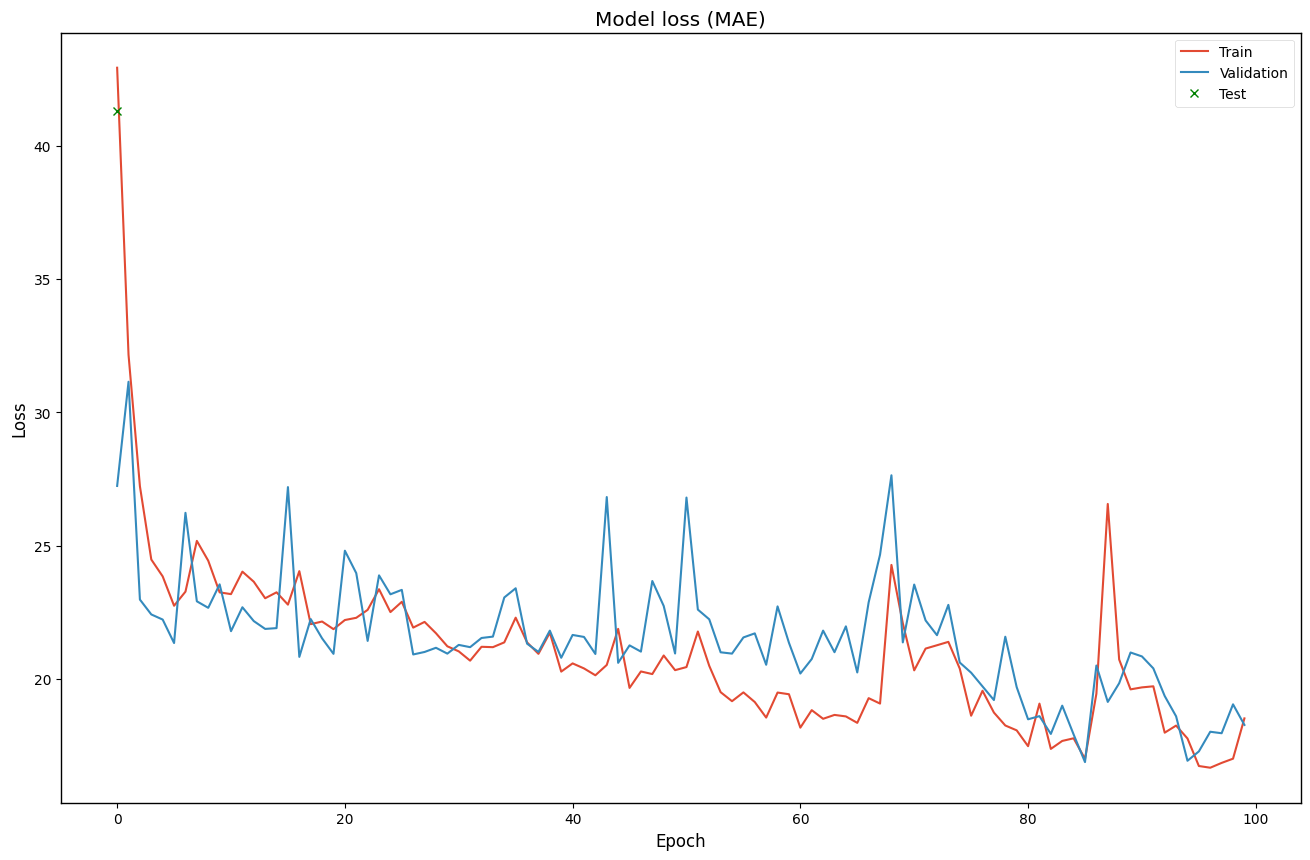

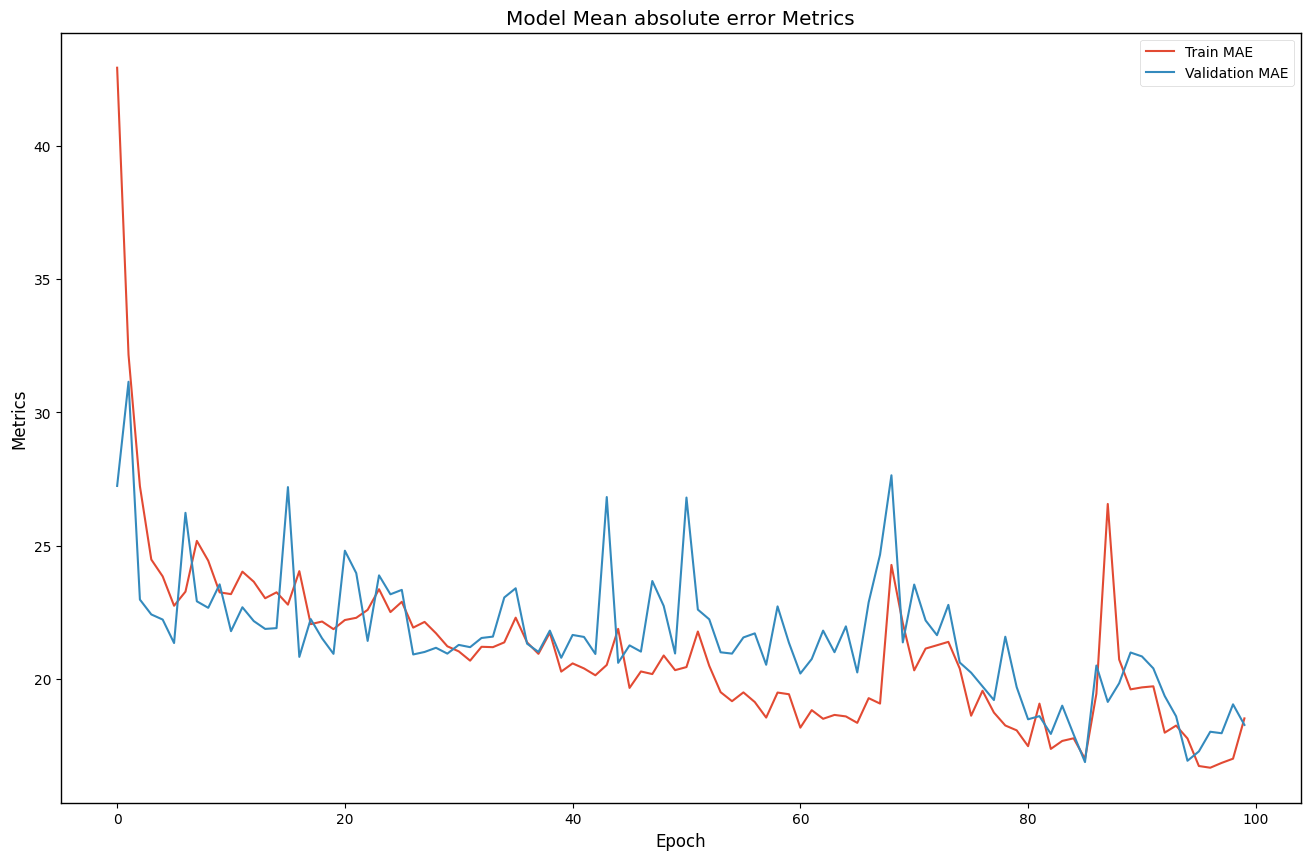

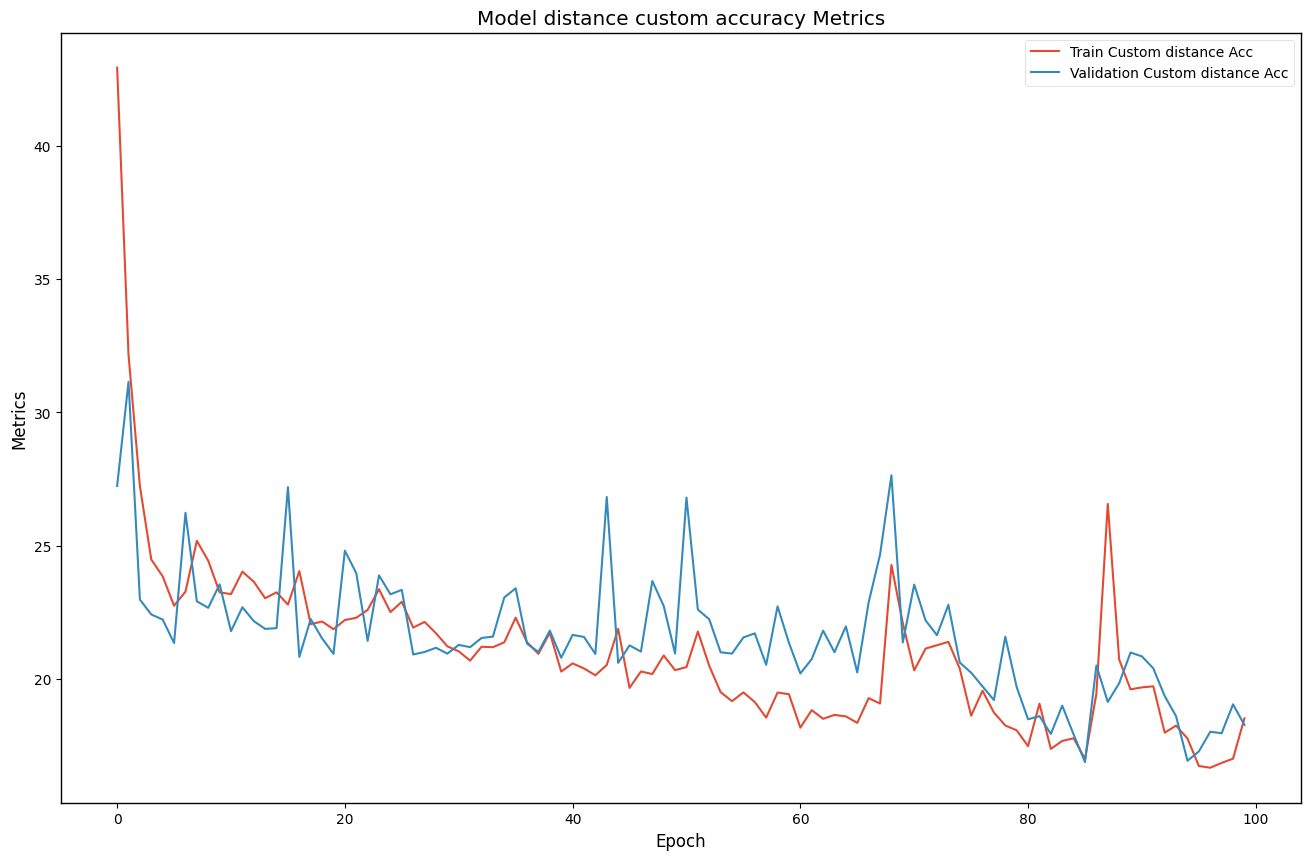

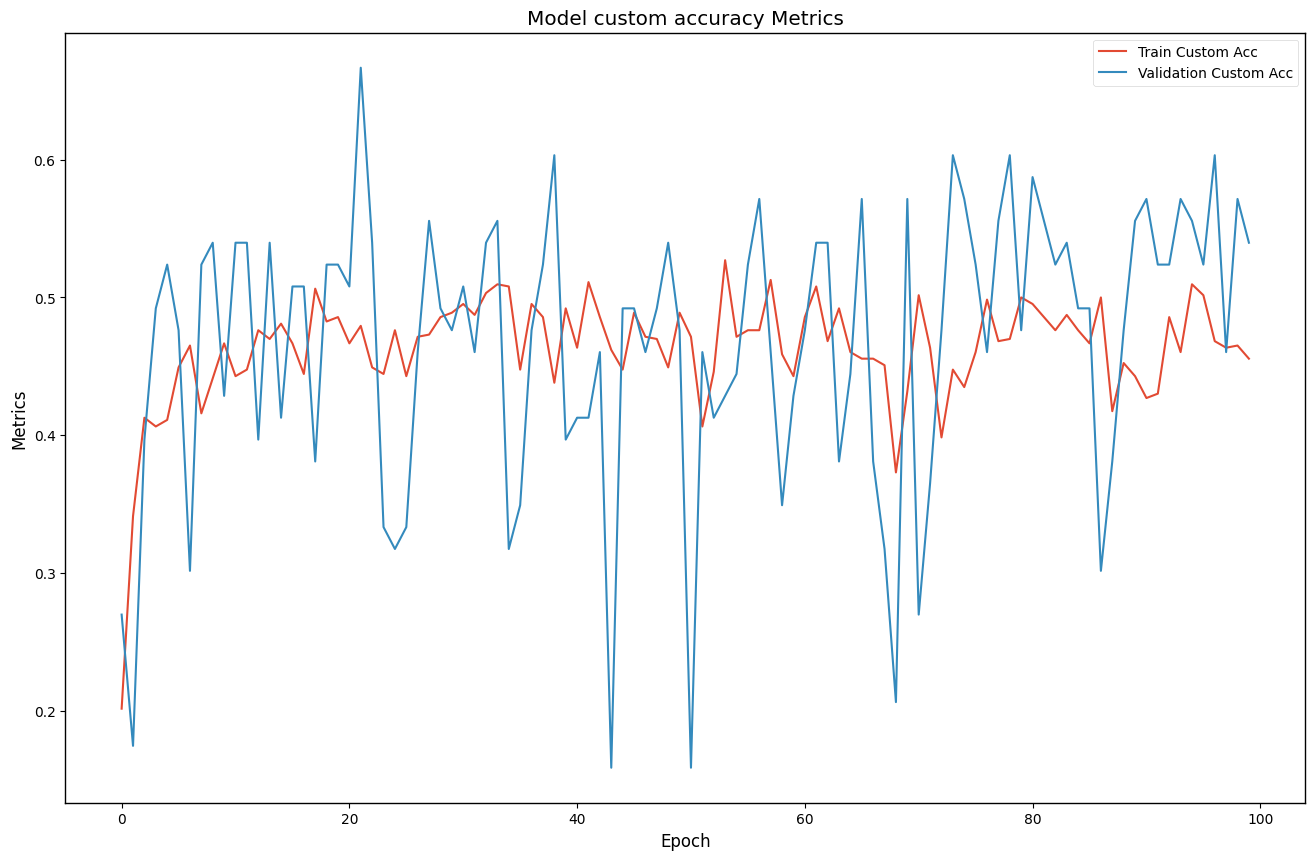

In [87]:
def plot_loss_and_accuracy(history, test_loss):

    # plot the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(test_loss, 'gx', label='Test Loss')
    
    plt.title('Model loss (MAE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
    plt.show()

    # Plot the training and validation mean absolute error
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])

    plt.title('Model Mean absolute error Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')
    plt.show()

    plt.plot(history.history['custom_distance_accuracy'])
    plt.plot(history.history['val_custom_distance_accuracy'])

    plt.title('Model distance custom accuracy Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train Custom distance Acc', 'Validation Custom distance Acc'], loc='upper right')
    plt.show()

    plt.plot(history.history['custom_accuracy'])
    plt.plot(history.history['val_custom_accuracy'])

    plt.title('Model custom accuracy Metrics')
    plt.ylabel('Metrics')
    plt.xlabel('Epoch')
    plt.legend(['Train Custom Acc', 'Validation Custom Acc'], loc='upper right')
    plt.show()

# Evaluate the model on the training and validation sets
tloss_value, tcustom_accuracy_value, tcustom_distance_accuracy,  tmean_absolute_error_value = model.evaluate(x_train10, y_train10)
vloss_value, vcustom_accuracy_value, vcustom_distance_accuracy, vmean_absolute_error_value = model.evaluate(x_val10, y_val10)
loss_value, custom_accuracy_value, custom_distance_accuracy, mean_absolute_error_value = model.evaluate(X10_test, Y10_test)
print(f"Train Mean absolute error: {tmean_absolute_error_value}, Validation Mean absolute error: {vmean_absolute_error_value}, (Test Mean absolute error: {mean_absolute_error_value})")
print(f"Train Custom accuracy value: {tcustom_accuracy_value}, Validation Custom accuracy value: {vcustom_accuracy_value}, (Test Custom accuracy value: {custom_accuracy_value})")
print(f"Train Custom distance accuracy value: {tcustom_distance_accuracy}, Validation Custom distance accuracy value: {vcustom_distance_accuracy}, (Test Custom distance accuracy value: {custom_distance_accuracy})")
    
plot_loss_and_accuracy(history, loss_value)

34
2/2 [==============================] - 0s 7ms/step
Mean: 41.32841671214384
Median: 17.558460235595703
Mode: 4.087852478027344
Standard Deviation: 77.34907482241339
Variance: 5982.879375883304
Range: 366.94408416748047
Percentage of values under 30: 76.47058823529412%
In 1 SD there is 91.17647058823529%
In 2 SD there is 2.941176470588232%
In 3 SD there is 2.941176470588246%
In 4 SD there is 0.0%
In 5 SD there is 2.941176470588232%
In 6 SD there is 0.0%


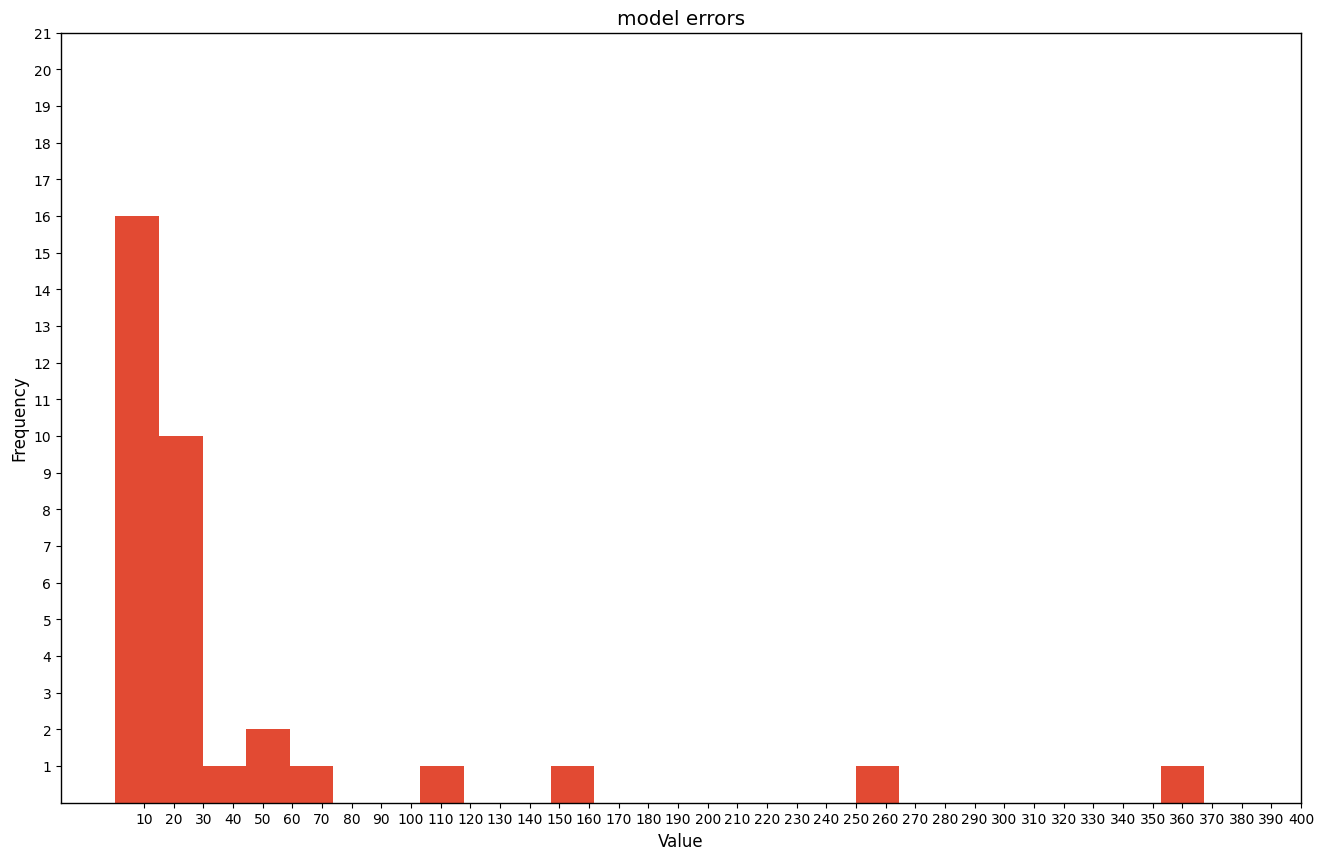

In [85]:
print(len(X10_test))
errors = []
predictions = model.predict(X10_test)
for pred, real in zip(predictions,Y10_test):
    errors.append(float(abs(pred - real)))

# Calculate the mean
mean = statistics.mean(errors)
# Calculate the median
median = statistics.median(errors)
# Calculate the mode
mode = statistics.mode(errors)
# Calculate the standard deviation
std_dev = statistics.stdev(errors)
# Calculate the variance
variance = statistics.variance(errors)
# Calculate the range
data_range = max(errors) - min(errors)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("Range:", data_range)

# Create a histogram plot
plt.hist(errors, bins='auto')
plt.xticks(range(10, 410, 10))
plt.yticks(range(1, 22))

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('model errors')

percentage_under_30 = (sum(error < 30 for error in errors) / len(errors)) * 100
print(f"Percentage of values under 30: {percentage_under_30}%")

mean = np.mean(errors)
std_dev = np.std(errors)

percentages = []
for i in range(1, 7):
    lower_bound = mean - (i * std_dev)
    upper_bound = mean + (i * std_dev)
    percentage = np.mean((lower_bound <= errors) & (errors <= upper_bound)) * 100
    percentages.append(percentage)

for i, percentage in enumerate(percentages, start=1):
    if i == 1:
        print(f"In {i} SD there is {percentage}%")
    else:
        previous_percentage = percentages[i - 2]
        range_percentage = percentage - previous_percentage
        print(f"In {i} SD there is {percentage - previous_percentage}%")

630
20/20 [==============================] - 0s 3ms/step
Mean: 16.11111111111111
Median: 8.0
Mode: 1
Standard Deviation: 34.737906296992115
Variance: 1206.7221338986044
Range: 337
Percentage of values under 30: 89.52380952380953%
In 1 SD there is 94.12698412698413%
In 2 SD there is 3.0158730158730123%
In 3 SD there is 1.4285714285714448%
In 4 SD there is 0.0%
In 5 SD there is 0.3174603174603021%
In 6 SD there is 0.15873015873016527%


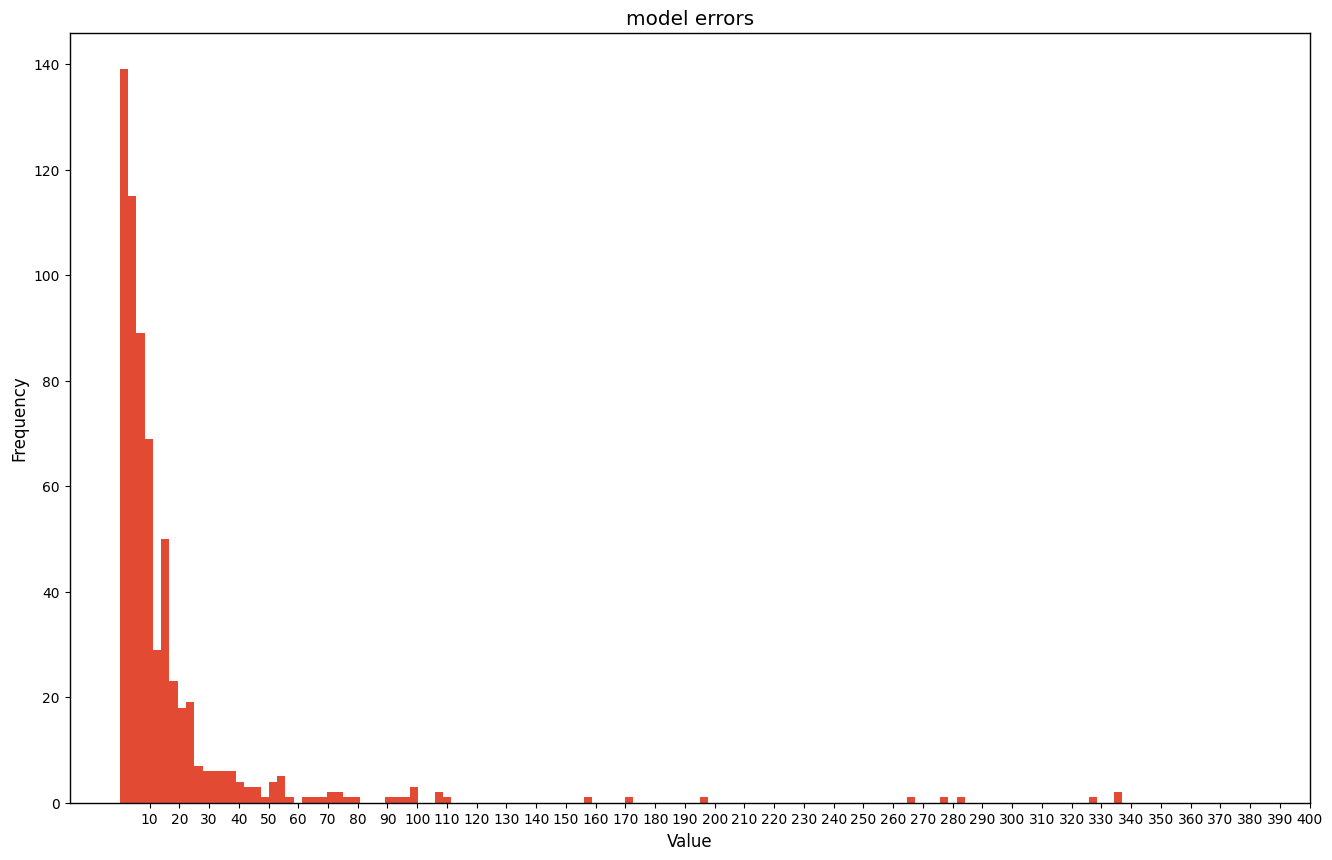

In [84]:
print(len(X10_train))
errors = []
predictions = model.predict(X10_train)
for pred, real in zip(predictions,Y10_train):
    errors.append(int(abs(pred - real)))

# Calculate the mean
mean = statistics.mean(errors)
# Calculate the median
median = statistics.median(errors)
# Calculate the mode
mode = statistics.mode(errors)
# Calculate the standard deviation
std_dev = statistics.stdev(errors)
# Calculate the variance
variance = statistics.variance(errors)
# Calculate the range
data_range = max(errors) - min(errors)

print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("Range:", data_range)

# Create a histogram plot
plt.hist(errors, bins='auto')
plt.xticks(range(10, 410, 10))

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('model errors')

percentage_under_30 = (sum(error < 30 for error in errors) / len(errors)) * 100
print(f"Percentage of values under 30: {percentage_under_30}%")

mean = np.mean(errors)
std_dev = np.std(errors)

percentages = []
for i in range(1, 7):
    lower_bound = mean - (i * std_dev)
    upper_bound = mean + (i * std_dev)
    percentage = np.mean((lower_bound <= errors) & (errors <= upper_bound)) * 100
    percentages.append(percentage)

for i, percentage in enumerate(percentages, start=1):
    if i == 1:
        print(f"In {i} SD there is {percentage}%")
    else:
        previous_percentage = percentages[i - 2]
        range_percentage = percentage - previous_percentage
        print(f"In {i} SD there is {percentage - previous_percentage}%")

In [ ]:
float_values = [float(np.ravel(arr)[0]) for arr in line16_default_small_tensor]
statistics.mean(float_values)

67.14752510368469